# Textbook Coding Lab Review

Here we're gonna review everything we did in the coding lab alongside the [sklearn.linear_model](https://scikit-learn.org/stable/api/sklearn.linear_model.html) documentation. This way we can ensure all best practices are up to date. It's also definitely gonna help further your understanding on how the whole process works for these different methodologies.

Our objective is to predict a baseball player's `Salary` based on various metrics associated with performance. Before we do any of that, let's load in the data and inspect it.

# Data Inspection and Preparation

In [825]:
from ISLP import load_data
import numpy as np
import pandas as pd
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns
import time
import itertools
import statsmodels.api as sm

Hitters = load_data("Hitters")

In [826]:
Hitters.head(10)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A
6,185,37,1,23,8,21,2,214,42,1,30,9,24,N,E,76,127,7,70.0,A
7,298,73,0,24,24,7,3,509,108,0,41,37,12,A,W,121,283,9,100.0,A
8,323,81,6,26,32,8,2,341,86,6,32,34,8,N,W,143,290,19,75.0,N
9,401,92,17,49,66,65,13,5206,1332,253,784,890,866,A,E,0,0,0,1100.0,A


In [827]:
print(f"NaN values: {np.isnan(Hitters["Salary"]).sum()}")
Hitters = Hitters.dropna()
print(f"Shape: {Hitters.shape}")
Hitters.dtypes

NaN values: 59
Shape: (263, 20)


AtBat           int64
Hits            int64
HmRun           int64
Runs            int64
RBI             int64
Walks           int64
Years           int64
CAtBat          int64
CHits           int64
CHmRun          int64
CRuns           int64
CRBI            int64
CWalks          int64
League       category
Division     category
PutOuts         int64
Assists         int64
Errors          int64
Salary        float64
NewLeague    category
dtype: object

## One-Hot Encode Categorical Data

Now we'll one-hot encode the categorical data columns using `sklearn`'s [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

**I'm still a bit uncertain of whether or not I should one-hot encode before or after a data split**... or if the order even matters. However, for simplicity, we're just gonna one-hot encode before the data split.

The categorical columns are:
* `League`
* `Division`
* `NewLeague`

I also think it might be ideal to leave the original `Hitters` data as a `pandas` data frame in case I need to inspect it later. I believe `pandas` would be best for this if the need arises.

In [828]:
Hitters = pd.get_dummies(Hitters, columns=["League", "Division", "NewLeague"], drop_first=True)
Hitters = Hitters.astype("float32") # Use `float32` for computational efficiency

print(type(Hitters))
Hitters.head(10)

<class 'pandas.core.frame.DataFrame'>


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
1,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,475.000000,1.0,1.0,1.0
2,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,480.000000,0.0,1.0,0.0
3,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,500.000000,1.0,0.0,1.0
4,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,91.500000,1.0,0.0,1.0
5,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,750.000000,0.0,1.0,0.0
6,185.0,37.0,1.0,23.0,8.0,21.0,2.0,214.0,42.0,1.0,30.0,9.0,24.0,76.0,127.0,7.0,70.000000,1.0,0.0,0.0
7,298.0,73.0,0.0,24.0,24.0,7.0,3.0,509.0,108.0,0.0,41.0,37.0,12.0,121.0,283.0,9.0,100.000000,0.0,1.0,0.0
8,323.0,81.0,6.0,26.0,32.0,8.0,2.0,341.0,86.0,6.0,32.0,34.0,8.0,143.0,290.0,19.0,75.000000,1.0,1.0,1.0
9,401.0,92.0,17.0,49.0,66.0,65.0,13.0,5206.0,1332.0,253.0,784.0,890.0,866.0,0.0,0.0,0.0,1100.000000,0.0,0.0,0.0
10,574.0,159.0,21.0,107.0,75.0,59.0,10.0,4631.0,1300.0,90.0,702.0,504.0,488.0,238.0,445.0,22.0,517.143005,0.0,0.0,0.0


## Split Data into Train and Test Sets

Now we'll split the data into train and test sets using `scikit`'s [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [829]:
# Split into train and test data
X, y = Hitters.drop("Salary", axis=1).to_numpy(), Hitters["Salary"].to_numpy() # Convert to `numpy` for future operations
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X, y, 
                                                                        test_size=0.2, 
                                                                        random_state=0)

print(f"X_train\nType: {type(X_train)}\nDtype: {X_train.dtype}\nShape: {X_train.shape}")
print()
print(f"y_train\nType: {type(y_train)}\nDtype: {y_train.dtype}\nShape: {y_train.shape}")

X_train
Type: <class 'numpy.ndarray'>
Dtype: float32
Shape: (210, 19)

y_train
Type: <class 'numpy.ndarray'>
Dtype: float32
Shape: (210,)


## Visualize Feature and Label Correlations

Now that we have `X` and `y`, let's visualize how each label (or coefficient) is related to the feature.

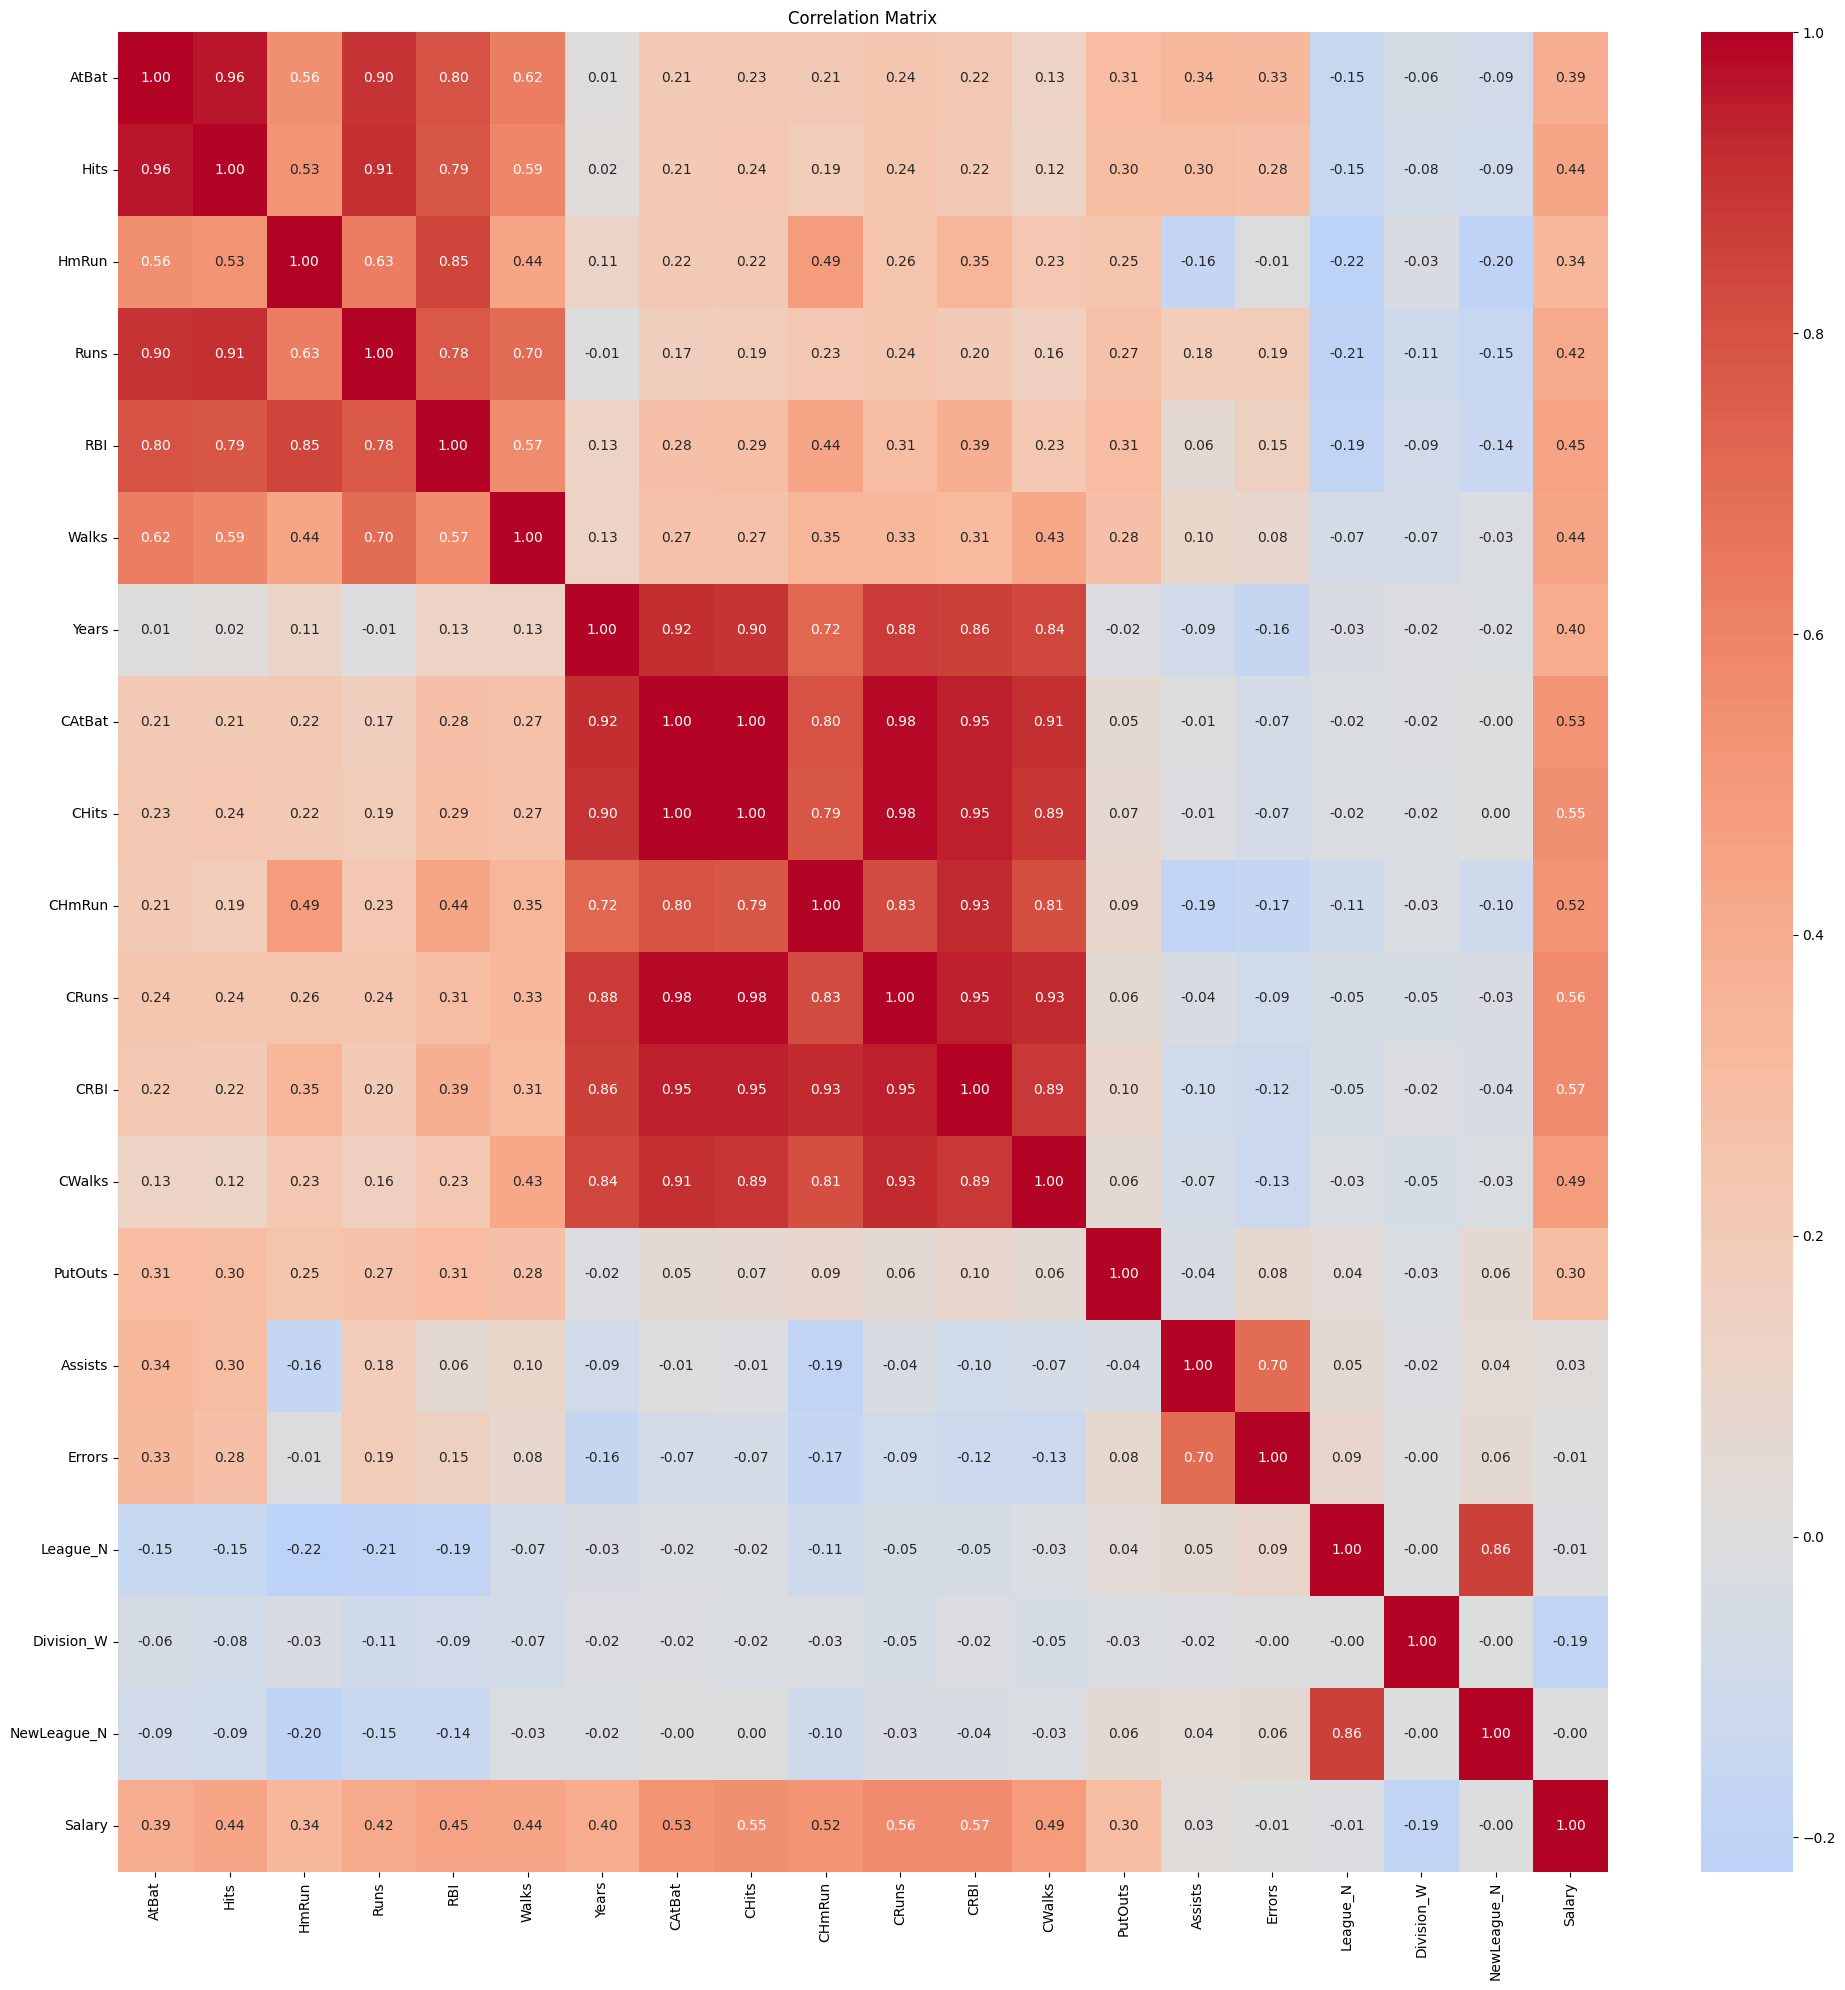

In [830]:
Xy_corrcoef = np.corrcoef(X.T, y)

# Add feature labels
feature_names = list(Hitters.drop("Salary", axis=1).columns) + ['Salary']

plt.figure(figsize=(20, 20))
sns.heatmap(Xy_corrcoef, 
            xticklabels=feature_names,
            yticklabels=feature_names,
            cmap='coolwarm', 
            center=0,
            annot=True,
            fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

I'm not entirely sure how useful visualizing correlation matrices is gonna be further down the line, but it's still a practice worth keeping in mind. Might be useful for referencing to when we get the results.

# Forward Stepwise Selection

We'll start subset selection with forward stepwise selection, as it seems no one uses best subset selection.

**A quick review:**

Forward stepwise selection begins with a model containing no predictors, and then add predictors to the model, one-at-a-time, until all of the predictors are in the model. In particular, at each step the variable that gives the greatest additional improvement to the fit is added to the model.

We'll begin by estimating the the test MSE using Cp, AIC, and BIC to see how each performs separately.

And remember that, by default, `sklearn` tries to maximize a score, hence our scoring function computed the negative Cp statistic.

In [842]:
def Cp(x_train, y_train, sigma2): 
    n, d = x_train.shape # `d` is a term for predictors (p) for subset models

    # Calculate OLS for RSS calculation
    model = sm.OLS(y_train, x_train).fit()
    Yhat = model.predict(x_train)

    # We use the training RSS when calculating Cp
    RSS = np.sum((y_train - Yhat)**2)

    #print(Yhat)
    #print(RSS)

    Cp_value = (RSS + 2 * d * sigma2) / n
    return Cp_value

sigma2 = sm.OLS(y_train, X_train).fit().scale
print(sigma2)
Cp(X_train, y_train, sigma2)

95980.05235602094


np.float64(104663.97137870856)

Now we need to estimate the residual variance `sigma2`, which is the first argument in our scoring function above. We will fit the biggest model, using all the variables, and estimate `sigma2` based on its MSE.